In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

In [2]:
#image = cv.imread('1.png')
image = cv.imread('2.jpg')

In [3]:
image.shape

(474, 864, 3)

In [4]:
def imshow(img):
    if len(img.shape) == 3: 
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        plt.imshow(img)
    else:
        plt.imshow(img, cmap=plt.cm.gray) 
    plt.show()

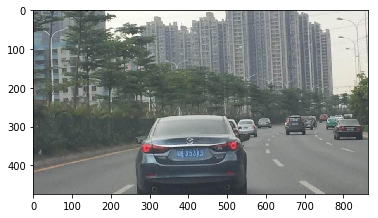

In [5]:
imshow(image)

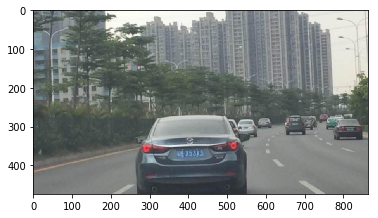

In [6]:
image = cv.GaussianBlur(image, (3, 3), 0)
imshow(image)

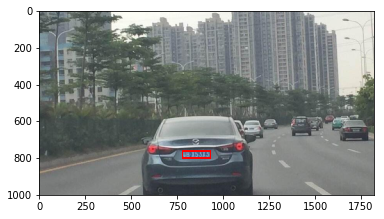

In [7]:


resize_h = 1000


resize_w = int(image.shape[1] / image.shape[0] * resize_h)


image = cv.resize(image, (resize_w, resize_h))


image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)


clf = cv.CascadeClassifier('./plate.xml')
area = clf.detectMultiScale(image_gray)


image2 = image.copy()
for (x, y, w, h) in area:

    cv.rectangle(image2, (x, y), (x + w, y + h), (0, 0, 255), 5)
imshow(image2)

In [8]:
print(x, y, x + w, y + h)

779 760 931 799


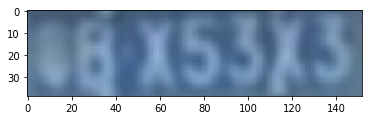

In [9]:
imshow(image[y:y + h,x:x+w])

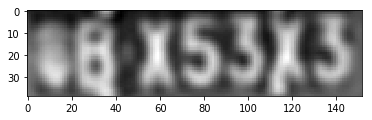

In [10]:
gray_img = image_gray[y:y+h, x:x+w]
imshow(gray_img)

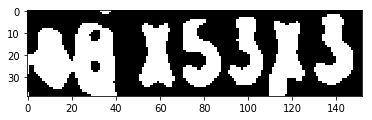

In [11]:
#二值化
ret, gray_img = cv.threshold(gray_img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
imshow(gray_img)

In [12]:
gray_img.shape

(39, 152)

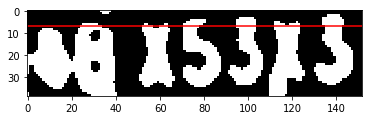

In [13]:

plt.plot([0,500], [7,7], color='r')
plt.plot([0,500], [76,76], color='r')
imshow(gray_img)

In [14]:

#print(sum(gray_img[4,:]))
#print(sum(gray_img[78,:]))

In [15]:
#print(sum(gray_img[40,:]))
#print(sum(gray_img[50,:]))

In [16]:
row_lines = np.sum(gray_img, axis=1)
row_lines.shape 

(39,)

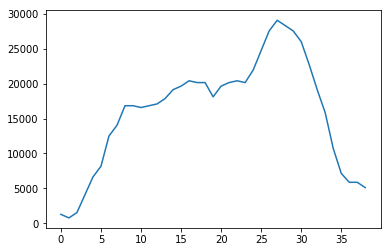

In [17]:
plt.plot(row_lines)
plt.show()

In [18]:
threshold = (row_lines.min() + row_lines.mean()) / 2
print(threshold)
#threshold = 31000

8411.73076923077


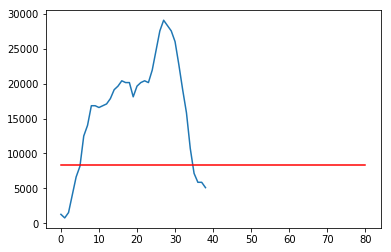

In [19]:
plt.plot(row_lines)
plt.plot([0,80], [threshold,threshold], color='r')
plt.show()

In [20]:

up_point = -1

is_up = True  
if row_lines[0] > threshold:
    up_point = 0
    up = False

wave_peaks = []
for i, x in enumerate(row_lines):
    
    if is_up:
       
        if x >= threshold:
            is_up = False
            up_point = i
        
    else:
       
        if x < threshold and i - up_point > 2:
            is_up = True
            wave_peaks.append((up_point, i))
        
if not is_up and up_point != -1 and i - up_point > 4:
    wave_peaks.append((up_point, i))

wave_peaks

[(6, 35)]

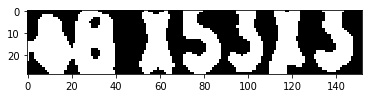

In [21]:
wave = max(wave_peaks, key=lambda x: x[1] - x[0])
gray_img = gray_img[wave[0]:wave[1]]
imshow(gray_img)

In [22]:
gray_img.shape

(29, 152)

In [23]:
def find_waves(threshold, row_lines):

    up_point = -1

    is_up = True 
    if row_lines[0] > threshold:
        up_point = 0
        up = False

    wave_peaks = []
    for i, x in enumerate(row_lines):

        if is_up:
            
            if x >= threshold:
                is_up = False
                up_point = i

        else:
           
            if x < threshold and i - up_point > 2:
                is_up = True
                wave_peaks.append((up_point, i))

    if not is_up and up_point != -1 and i - up_point > 4:
        wave_peaks.append((up_point, i))
    
    return wave_peaks

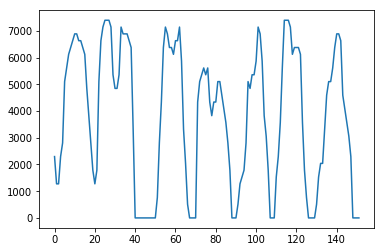

In [24]:
column_lines = np.sum(gray_img, axis=0)
plt.plot(column_lines)
plt.show()

In [25]:
threshold = (column_lines.min() + column_lines.mean()) / 5   # U和0要求阈值偏小，否则U和0会被分成两半

threshold

762.9868421052631

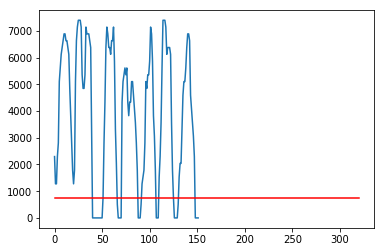

In [26]:
plt.plot(column_lines)
plt.plot([0,320], [threshold,threshold], color='r')
plt.show()

In [27]:
wave_peaks = find_waves(threshold, column_lines)
wave_peaks

[(0, 40), (51, 66), (71, 88), (92, 107), (110, 126), (131, 148)]

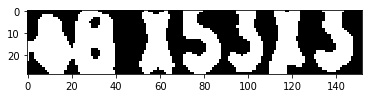

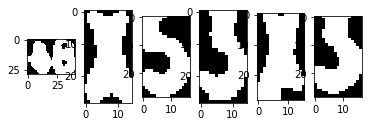

In [28]:
imshow(gray_img)

length = len(wave_peaks)
for i in range(length):
    plt.subplot(1, length, i+1)
    plt.imshow(gray_img[:,wave_peaks[i][0]:wave_peaks[i][1]], cmap=plt.cm.gray)

plt.show()

In [29]:
def seperate_card(img, waves):
    part_cards = []
    for wave in waves:
        part_cards.append(img[:, wave[0]:wave[1]])
    return part_cards

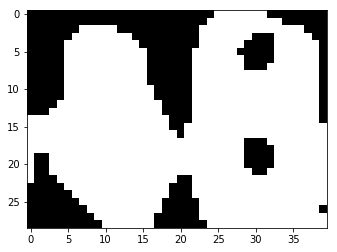

In [30]:
part_cards = seperate_card(gray_img, wave_peaks)
imshow(part_cards[0])

In [31]:
from numpy.linalg import norm
def preprocess_hog(digits):
    samples = []
    for img in digits:
        gx = cv.Sobel(img, cv.CV_32F, 1, 0)
        gy = cv.Sobel(img, cv.CV_32F, 0, 1)
        mag, ang = cv.cartToPolar(gx, gy)
        bin_n = 16
        bin = np.int32(bin_n*ang/(2*np.pi))
        bin_cells = bin[:10,:10], bin[10:,:10], bin[:10,10:], bin[10:,10:]
        mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
        hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
        hist = np.hstack(hists)

        # transform to Hellinger kernel
        eps = 1e-7
        hist /= hist.sum() + eps
        hist = np.sqrt(hist)
        hist /= norm(hist) + eps

        samples.append(hist)
    return np.float32(samples)

In [32]:
from sklearn.externals import joblib
model_zh = joblib.load('plate.zh')

# 部份省份
provinces = [
    "zh_cuan", "川",
    "zh_e", "鄂",
    "zh_gan", "赣",
    "zh_gan1", "甘",
    "zh_gui", "贵",
    "zh_gui1", "桂",
    "zh_hei", "黑",
    "zh_hu", "沪",
    "zh_ji", "冀",
    "zh_jin", "津",
    "zh_jing", "京",
    "zh_jl", "吉",
    "zh_liao", "辽",
    "zh_lu", "鲁",
    "zh_meng", "蒙",
    "zh_min", "闽",
    "zh_ning", "宁",
    "zh_qing", "靑",
    "zh_qiong", "琼",
    "zh_shan", "陕",
    "zh_su", "苏",
    "zh_sx", "晋",
    "zh_wan", "皖",
    "zh_xiang", "湘",
    "zh_xin", "新",
    "zh_yu", "豫",
    "zh_yu1", "渝",
    "zh_yue", "粤",
    "zh_yun", "云",
    "zh_zang", "藏",
    "zh_zhe", "浙"
]

In [33]:
SZ = 20        
part_card = part_cards[0]
part_card_old = part_card
w = abs(part_card.shape[1] - SZ) // 2
w

10

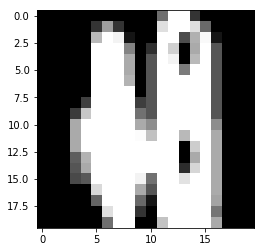

In [34]:
part_card = cv.copyMakeBorder(part_card, 0, 0, w, w, cv.BORDER_CONSTANT, value=[0, 0, 0])
part_card = cv.resize(part_card, (SZ, SZ), interpolation=cv.INTER_AREA)
imshow(part_card)

In [35]:
part_card = preprocess_hog([part_card])
part_card.shape

(1, 64)

In [36]:
ret = model_zh.predict(part_card)
provinces[int(ret[0])]

'川'

In [37]:
from sklearn.externals import joblib
model_en = joblib.load('plate.en')

In [38]:
res = []
for i, part_card in enumerate(part_cards):
    
    SZ = 20  
    part_card_old = part_card
    w = abs(part_card.shape[1] - SZ) // 2
    part_card = cv.copyMakeBorder(part_card, 0, 0, w, w, cv.BORDER_CONSTANT, value=[0, 0, 0])
    part_card = cv.resize(part_card, (SZ, SZ), interpolation=cv.INTER_AREA)
    part_card = preprocess_hog([part_card])
    
    if i == 0 :
        ret = model_zh.predict(part_card)
        char = provinces[int(ret[0])]
    else:
        
        if np.mean(part_card_old) < 255 / 5:
            print("a point")
            continue

        ret = model_en.predict(part_card)
        char = chr(int(ret[0]))
        
    res.append(char)
    
res

['川', 'X', 'S', '3', 'X', '3']